In [27]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym.mujoco import Parameters

from nmf_grooming import (
    NeuromechflyGrooming,
    all_groom_dofs,
    load_grooming_data,
    plot_state_and_contacts,
)
from scipy.signal import find_peaks, medfilt

In [28]:
timestep = 2e-4
data_block = load_grooming_data("./data/grooming_sequence.pkl", timestep)

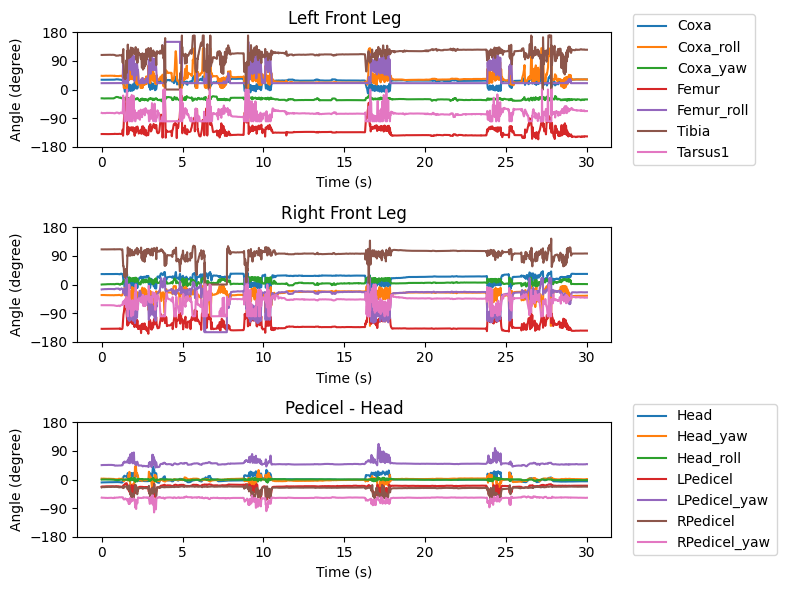

In [29]:
def plot_grooming_kinematics(data_block, t, dof=all_groom_dofs):
    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    appendages = [
        f"{side} {pos}" for pos in ["Front Leg"] for side in ["Left", "Right"]
    ] + ["Pedicel - Head"]

    for i, app in enumerate(appendages):
        ax = axs.flatten()[i]
        app_code = f"{app.split()[0][0]}{app.split()[1][0]}".upper()
        for j, dof in enumerate(all_groom_dofs):
            if app_code in dof:
                ax.plot(t, np.rad2deg(data_block[j, :]), label=dof[8:])
            elif not "Leg" in app and ("Head" in dof or "Pedicel" in dof):
                ax.plot(t, np.rad2deg(data_block[j, :]), label=dof[6:])
            else:
                continue
        ax.set_ylim(-180, 180)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle (degree)")
        ax.set_yticks([-180, -90, 0, 90, 180])
        ax.set_title(app)
        if i == 0 or i == 2:
            ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    return fig


experiment_time = np.arange(0, data_block.shape[1] * timestep, timestep)
fig = plot_grooming_kinematics(data_block, experiment_time)

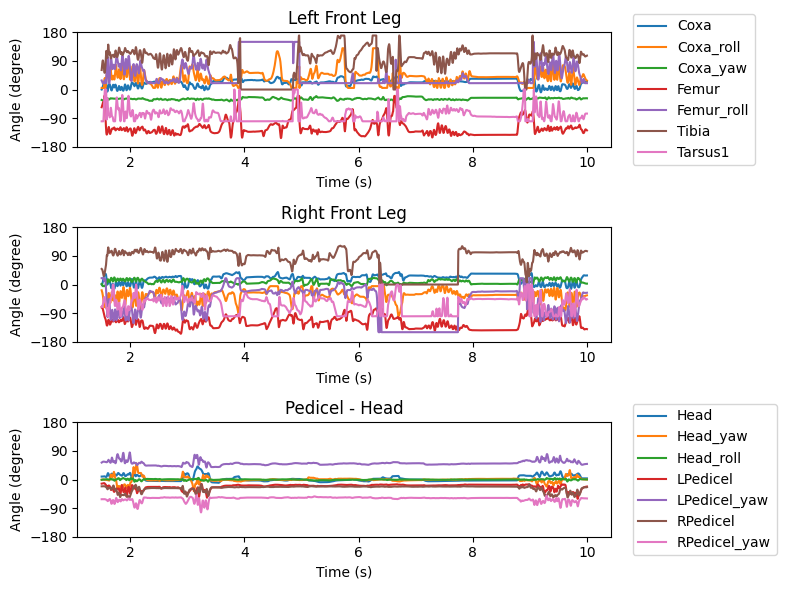

In [30]:
start_time = 1.5  # 1.5
end_time = 10.0  # 3.5
start_idx = int(start_time / timestep)
end_idx = int(end_time / timestep)
data_block_focus = data_block[:, start_idx:end_idx]
time_focus = experiment_time[start_idx:end_idx]

fig = plot_grooming_kinematics(data_block_focus, time_focus)

In [31]:
target_num_steps = end_idx - start_idx

sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=False,
    actuator_kp=10.0,
    render_camera="Animat/camera_front",
)
nmf = NeuromechflyGrooming(sim_params=sim_params)
obs, info = nmf.reset()

obs_list = []

for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_focus[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

Path("visu/").mkdir(exist_ok=True)
nmf.save_video("visu/grooming_kinematic_replay.mp4", 0)

100%|██████████| 42500/42500 [00:40<00:00, 1039.52it/s]


In [32]:
# For the sake of simplicity we fix the antenna (motion in the antenna is hard to monitor as it might be caused by the grooming action or voluntary by the fly)
Rantenna_pitch_idx = nmf.actuated_joints.index("joint_RPedicel")
Lantenna_pitch_idx = nmf.actuated_joints.index("joint_LPedicel")
Rantenna_yaw_idx = nmf.actuated_joints.index("joint_RPedicel_yaw")
Lantenna_yaw_idx = nmf.actuated_joints.index("joint_LPedicel_yaw")

antenna_pitch_mean_pos = np.mean(
    data_block_focus[[Rantenna_pitch_idx, Lantenna_pitch_idx], :]
)
antenna_yaw_mean_pos = np.mean(
    data_block_focus[[Rantenna_yaw_idx, Lantenna_yaw_idx], :] * [[-1], [1]]
)
data_block_focus[Rantenna_pitch_idx, :] = antenna_pitch_mean_pos
data_block_focus[Lantenna_pitch_idx, :] = antenna_pitch_mean_pos
data_block_focus[Rantenna_yaw_idx, :] = -1 * antenna_yaw_mean_pos
data_block_focus[Lantenna_yaw_idx, :] = antenna_yaw_mean_pos

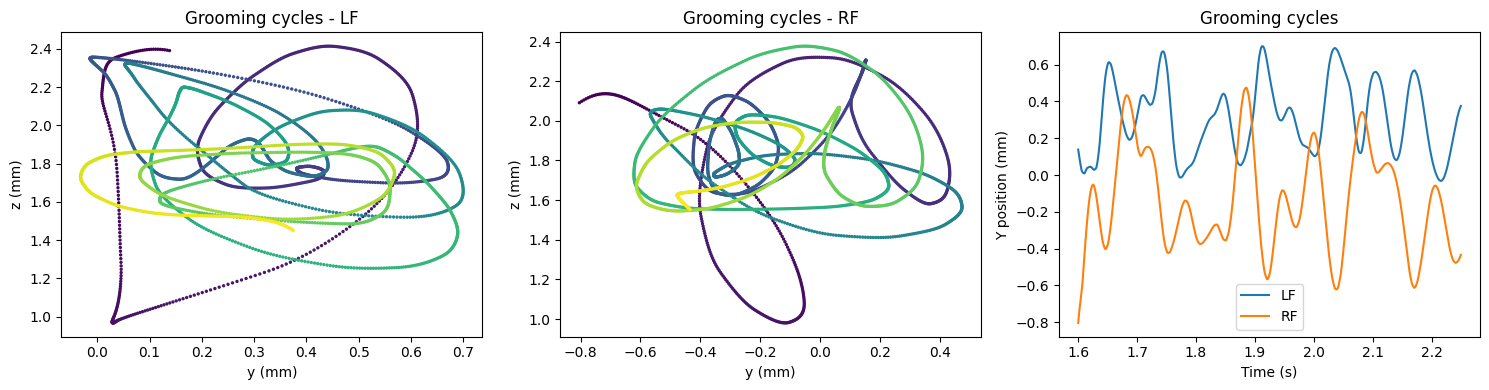

In [33]:
frontleg_tips = ("LF", "RF")
foreleg_end_effector_id = [
    i
    for i, leg_tip in enumerate(nmf._last_tarsalseg_names)
    if leg_tip.startswith(frontleg_tips)
]
foreleg_end_effector_positions = np.array(
    [obs["end_effectors"][foreleg_end_effector_id] for obs in obs_list]
).transpose(1, 0, 2)

# based on the video and the plotted joint angles we can identify the grooming cycles
ant_grooming_start_t = 1.6
ant_grooming_end_t = 2.25
ant_grooming_start_idx = (
    int(ant_grooming_start_t / sim_params.timestep) - start_idx
)  # timepoints are given in global time
ant_grooming_end_idx = int(ant_grooming_end_t / sim_params.timestep) - start_idx

ant_grooming_frontlegs_end_effector_positions = foreleg_end_effector_positions[
    :, ant_grooming_start_idx:ant_grooming_end_idx
]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

j = 0
for i, ee_pos in enumerate(ant_grooming_frontlegs_end_effector_positions):
    # Use scatter to have a change in color as time progresses
    axs[i].scatter(
        ee_pos[:, 1],
        ee_pos[:, 2],
        label=frontleg_tips[i],
        s=2,
        c=np.arange(len(ee_pos[:, 1])),
        cmap="viridis",
    )
    axs[i].set_xlabel("y (mm)")
    axs[i].set_ylabel("z (mm)")
    axs[i].set_title("Grooming cycles - " + frontleg_tips[i])

axs[2].plot(
    time_focus[ant_grooming_start_idx:ant_grooming_end_idx],
    ant_grooming_frontlegs_end_effector_positions[:, :, 1].T,
)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Y position (mm)")
axs[2].set_title("Grooming cycles")
axs[2].legend(frontleg_tips)
plt.tight_layout()

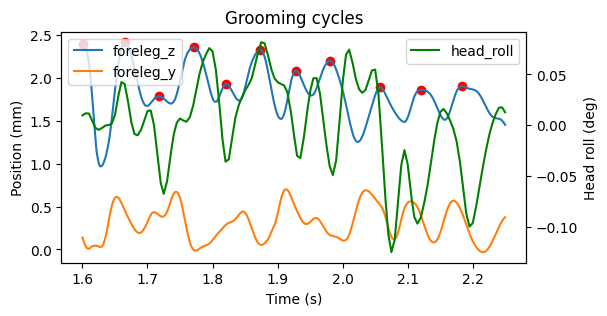

In [34]:
peaks, _ = find_peaks(ant_grooming_frontlegs_end_effector_positions[0, :, 2])

# Look at the z position to segment grooming cycles
ant_grooming_time = time_focus[ant_grooming_start_idx:ant_grooming_end_idx]

ax, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(
    ant_grooming_time,
    ant_grooming_frontlegs_end_effector_positions[0, :, 2],
    label="foreleg_z",
)
ax.scatter(
    ant_grooming_time[peaks],
    ant_grooming_frontlegs_end_effector_positions[0, :, 2][peaks],
    c="r",
)
ax.plot(
    ant_grooming_time,
    ant_grooming_frontlegs_end_effector_positions[0, :, 1],
    label="foreleg_y",
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (mm)")
ax.set_title("Grooming cycles")

twin_ax = ax.twinx()
head_roll_idx = all_groom_dofs.index("joint_Head_roll")
head_roll = data_block_focus[head_roll_idx, ant_grooming_start_idx:ant_grooming_end_idx]
twin_ax.plot(ant_grooming_time, head_roll, c="g", label="head_roll")
twin_ax.set_ylabel("Head roll (deg)")
ax.legend(loc="upper left")
twin_ax.legend(loc="upper right")

plt.show()

In [35]:
# Pick the best grooming cycle e.g the head roll seems to return to the same position
ant_cycle_grooming_start = peaks[-2] + ant_grooming_start_idx
ant_cycle_grooming_end = peaks[-1] + ant_grooming_start_idx

data_block_ant_grooming = data_block_focus[
    :, ant_cycle_grooming_start:ant_cycle_grooming_end
]

In [36]:
def make_cyclical(
    data, closure_window_size=int(200 / timestep * 1e-4), smooth_half_window_size=2
):
    # helper function to loop an extract of the data
    # The idea here is to close the data and smoothen the trace to make the transition smooth

    # close the data by interpolating between zeros and the difference between the first and last value in a closure window
    diff = data[:, 0] - data[:, -1]
    diff_ramp = np.linspace(0, diff, closure_window_size).T
    data_closed = data.copy()
    data_closed[:, -closure_window_size:] += diff_ramp

    # median_filter just to smooth the transition
    smooth_window_size = 2 * smooth_half_window_size + 1
    data_looped_expanded = np.concatenate(
        [
            data_closed[:, -smooth_half_window_size:],
            data_closed,
            data_closed[:, :smooth_half_window_size],
        ],
        axis=1,
    )
    data_cyclic = medfilt(data_looped_expanded, kernel_size=(1, smooth_window_size))[
        :, smooth_half_window_size:-smooth_half_window_size
    ]

    return data_cyclic

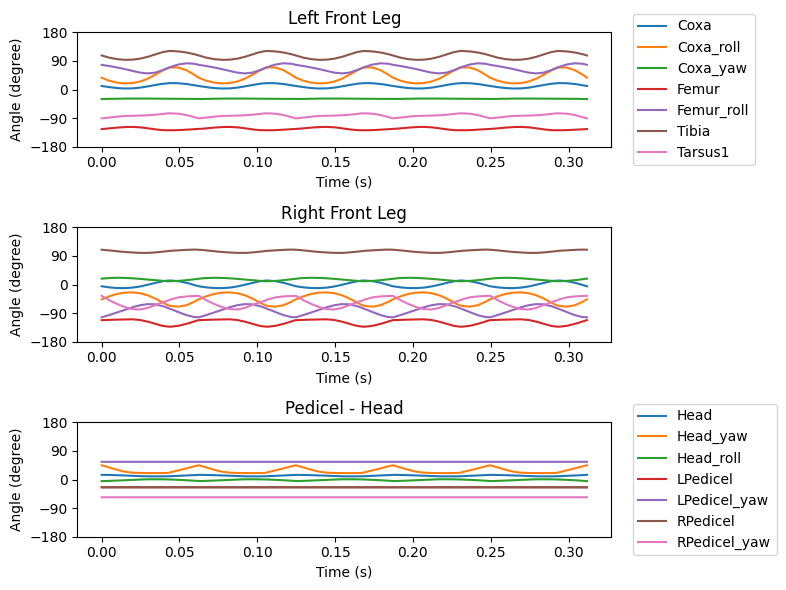

In [37]:
# plot the cycled data
n_cycles = 5
data_block_ant_grooming_smoothed = make_cyclical(data_block_ant_grooming)
data_block_ant_grooming_interp_cycled = np.tile(
    data_block_ant_grooming_smoothed, n_cycles
)

time = np.arange(len(data_block_ant_grooming_interp_cycled[0])) * sim_params.timestep
cycle_length = len(data_block_ant_grooming[0])

fig = plot_grooming_kinematics(data_block_ant_grooming_interp_cycled, time)

In [38]:
# replay the cycled grooming
obs, info = nmf.reset()

target_num_steps = data_block_ant_grooming_interp_cycled.shape[1]

for i in trange(target_num_steps):
    joint_pos = data_block_ant_grooming_interp_cycled[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

# as the left antenna is groomed, we call it left antennal grooming
nmf.save_video("visu/grooming_antennal_R_looped.mp4", 0)

100%|██████████| 1560/1560 [00:01<00:00, 1028.60it/s]


### Mirror the grooming behavior to get right antennal grooming

In [39]:
data_block_ant_grooming_smoothed_mirrored = np.zeros_like(
    data_block_ant_grooming_smoothed
)
for i, joint in enumerate(nmf.actuated_joints):
    if "Head" in joint:
        opp_joints_id = i
    elif joint.startswith("joint_L"):
        opp_joints_id = nmf.actuated_joints.index(joint.replace("joint_L", "joint_R"))
    else:
        opp_joints_id = nmf.actuated_joints.index(joint.replace("joint_R", "joint_L"))
    if "yaw" in joint or "roll" in joint:
        data_block_ant_grooming_smoothed_mirrored[
            i, :
        ] = -data_block_ant_grooming_smoothed[opp_joints_id, :]
    else:
        data_block_ant_grooming_smoothed_mirrored[
            i, :
        ] = data_block_ant_grooming_smoothed[opp_joints_id, :]

In [40]:
obs, info = nmf.reset()

data_block_ant_grooming_interp_cycled_mirrored = np.tile(
    data_block_ant_grooming_smoothed_mirrored, n_cycles
)
target_num_steps = data_block_ant_grooming_interp_cycled_mirrored.shape[1]

for i in trange(target_num_steps):
    joint_pos = data_block_ant_grooming_interp_cycled_mirrored[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("visu/grooming_antennal_L_looped.mp4", 0)

100%|██████████| 1560/1560 [00:01<00:00, 1029.83it/s]


### Foreleg grooming

We will apply the exact same strategy as for the antennal grooming

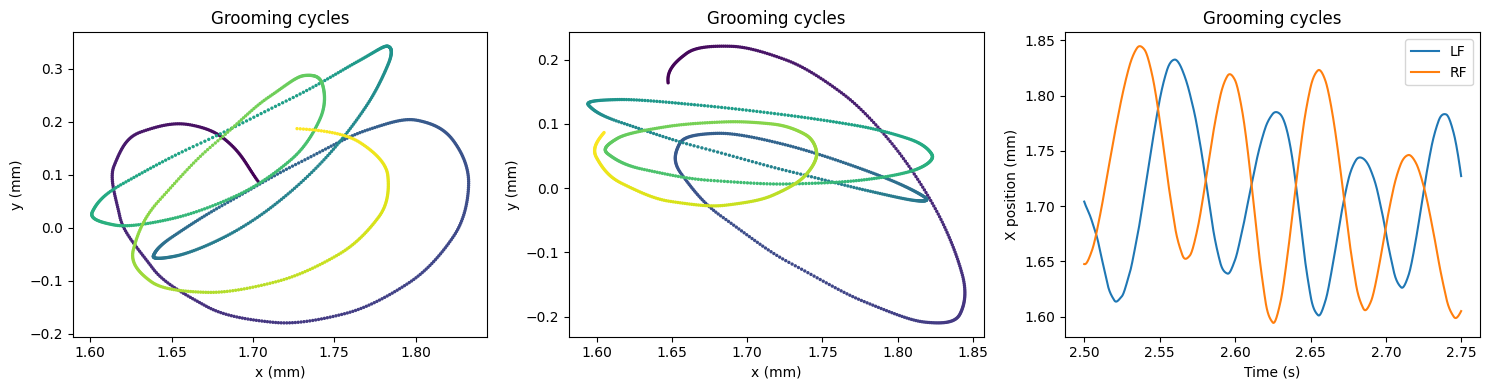

In [41]:
foreleg_grooming_start_t = 2.5
foreleg_grooming_end_t = 2.75

foreleg_grooming_start_idx = (
    int(foreleg_grooming_start_t / sim_params.timestep) - start_idx
)
foreleg_grooming_end_idx = int(foreleg_grooming_end_t / sim_params.timestep) - start_idx

foreleg_grooming_frontlegs_end_effector_positions = foreleg_end_effector_positions[
    :, foreleg_grooming_start_idx:foreleg_grooming_end_idx
]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, ee_pos in enumerate(foreleg_grooming_frontlegs_end_effector_positions):
    axs[i].scatter(
        ee_pos[:, 0],
        ee_pos[:, 1],
        label=frontleg_tips[i],
        s=2,
        c=np.arange(len(ee_pos[:, 1])),
        cmap="viridis",
    )
    axs[i].set_xlabel("x (mm)")
    axs[i].set_ylabel("y (mm)")
    axs[i].set_title("Grooming cycles")

axs[2].plot(
    time_focus[foreleg_grooming_start_idx:foreleg_grooming_end_idx],
    foreleg_grooming_frontlegs_end_effector_positions[:, :, 0].T,
)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("X position (mm)")
axs[2].set_title("Grooming cycles")
axs[2].legend(frontleg_tips)
plt.tight_layout()

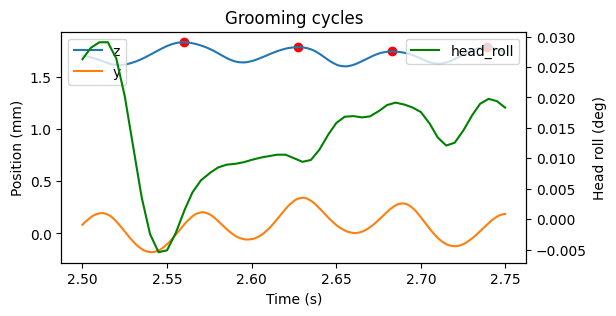

In [42]:
peaks, _ = find_peaks(foreleg_grooming_frontlegs_end_effector_positions[0, :, 0])

foreleg_time = time_focus[foreleg_grooming_start_idx:foreleg_grooming_end_idx]

# Look at the z position to segment grooming cycles
ax, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(
    foreleg_time, foreleg_grooming_frontlegs_end_effector_positions[0, :, 0], label="z"
)
ax.scatter(
    foreleg_time[peaks],
    foreleg_grooming_frontlegs_end_effector_positions[0, :, 0][peaks],
    c="r",
)
ax.plot(
    foreleg_time, foreleg_grooming_frontlegs_end_effector_positions[0, :, 1], label="y"
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (mm)")
ax.set_title("Grooming cycles")

twin_ax = ax.twinx()
head_roll_idx = all_groom_dofs.index("joint_Head_roll")
head_roll = data_block_focus[
    head_roll_idx, foreleg_grooming_start_idx:foreleg_grooming_end_idx
]
twin_ax.plot(foreleg_time, head_roll, c="g", label="head_roll")
twin_ax.set_ylabel("Head roll (deg)")
ax.legend(loc="upper left")
twin_ax.legend(loc="upper right")

plt.show()

In [43]:
# select the best foreleg grooming cycle
ant_cycle_grooming_start = peaks[2] + foreleg_grooming_start_idx
ant_cycle_grooming_end = peaks[3] + foreleg_grooming_start_idx

data_block_foreleg_grooming = data_block_focus[
    :, ant_cycle_grooming_start:ant_cycle_grooming_end
]

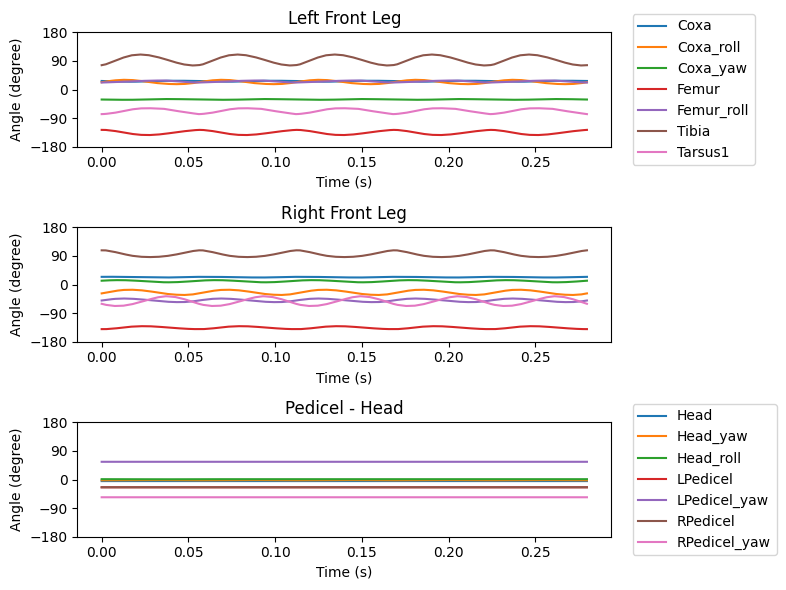

In [44]:
data_block_foreleg_grooming_smoothed = make_cyclical(data_block_foreleg_grooming)
data_block_foreleg_grooming_interp_cycled = np.tile(
    data_block_foreleg_grooming_smoothed, n_cycles
)

time = (
    np.arange(len(data_block_foreleg_grooming_interp_cycled[0])) * sim_params.timestep
)

fig = plot_grooming_kinematics(data_block_foreleg_grooming_interp_cycled, time)

In [45]:
obs, info = nmf.reset()

target_num_steps = data_block_foreleg_grooming_interp_cycled.shape[1]

for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_foreleg_grooming_interp_cycled[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("visu/grooming_foreleg_looped.mp4", 0)

100%|██████████| 1400/1400 [00:01<00:00, 1107.31it/s]


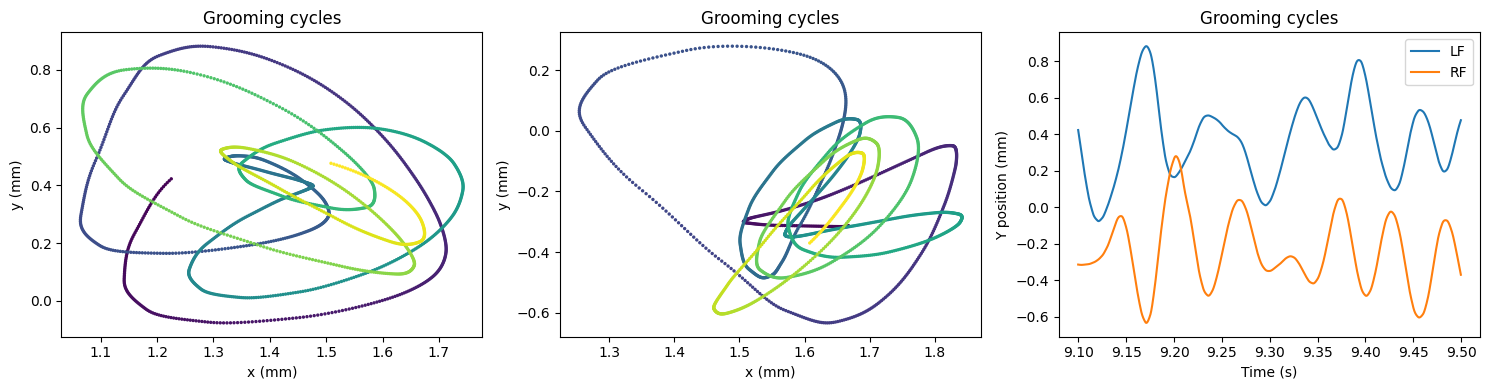

In [46]:
bilat_grooming_start_t = 9.1
bilat_grooming_end_t = 9.5

bilat_grooming_start_idx = int(bilat_grooming_start_t / sim_params.timestep) - start_idx
bilat_grooming_end_idx = int(bilat_grooming_end_t / sim_params.timestep) - start_idx

bilat_grooming_frontlegs_end_effector_positions = foreleg_end_effector_positions[
    :, bilat_grooming_start_idx:bilat_grooming_end_idx
]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, ee_pos in enumerate(bilat_grooming_frontlegs_end_effector_positions):
    axs[i].scatter(
        ee_pos[:, 0],
        ee_pos[:, 1],
        label=frontleg_tips[i],
        s=2,
        c=np.arange(len(ee_pos[:, 1])),
        cmap="viridis",
    )
    axs[i].set_xlabel("x (mm)")
    axs[i].set_ylabel("y (mm)")
    axs[i].set_title("Grooming cycles")

axs[2].plot(
    time_focus[bilat_grooming_start_idx:bilat_grooming_end_idx],
    bilat_grooming_frontlegs_end_effector_positions[:, :, 1].T,
)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Y position (mm)")
axs[2].set_title("Grooming cycles")
axs[2].legend(frontleg_tips)
plt.tight_layout()

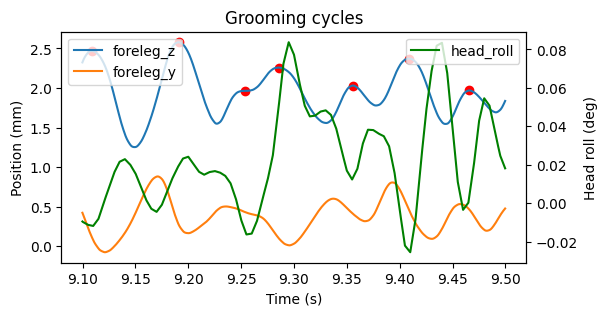

In [47]:
peaks, _ = find_peaks(bilat_grooming_frontlegs_end_effector_positions[0, :, 2])

# Look at the z position to segment grooming cycles
bilat_grooming_time = time_focus[bilat_grooming_start_idx:bilat_grooming_end_idx]

ax, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(
    bilat_grooming_time,
    bilat_grooming_frontlegs_end_effector_positions[0, :, 2],
    label="foreleg_z",
)
ax.scatter(
    bilat_grooming_time[peaks],
    bilat_grooming_frontlegs_end_effector_positions[0, :, 2][peaks],
    c="r",
)
ax.plot(
    bilat_grooming_time,
    bilat_grooming_frontlegs_end_effector_positions[0, :, 1],
    label="foreleg_y",
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (mm)")
ax.set_title("Grooming cycles")

twin_ax = ax.twinx()
head_roll_idx = all_groom_dofs.index("joint_Head_roll")
head_roll = data_block_focus[
    head_roll_idx, bilat_grooming_start_idx:bilat_grooming_end_idx
]
twin_ax.plot(bilat_grooming_time, head_roll, c="g", label="head_roll")
twin_ax.set_ylabel("Head roll (deg)")
ax.legend(loc="upper left")
twin_ax.legend(loc="upper right")

plt.show()

In [48]:
# Pick the best grooming cycle e.g the head roll seems to return to the same position
bilat_cycle_grooming_start = peaks[0] + bilat_grooming_start_idx
bilat_cycle_grooming_end = peaks[1] + bilat_grooming_start_idx

data_block_bilat_grooming = data_block_focus[
    :, bilat_cycle_grooming_start:bilat_cycle_grooming_end
]

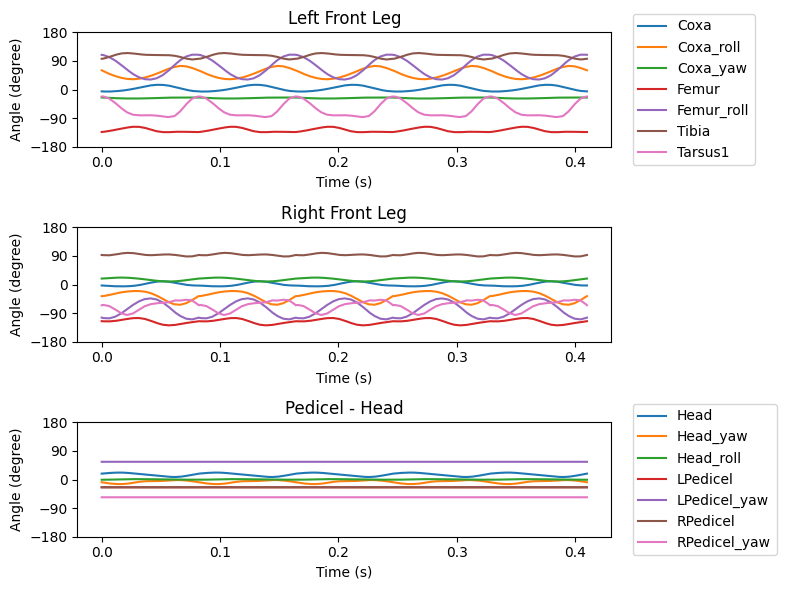

In [49]:
# plot the cycled data
n_cycles = 5
data_block_bilat_grooming_smoothed = make_cyclical(data_block_bilat_grooming)
data_block_bilat_grooming_interp_cycled = np.tile(
    data_block_bilat_grooming_smoothed, n_cycles
)

time = np.arange(len(data_block_bilat_grooming_interp_cycled[0])) * sim_params.timestep
cycle_length = len(data_block_bilat_grooming[0])

fig = plot_grooming_kinematics(data_block_bilat_grooming_interp_cycled, time)

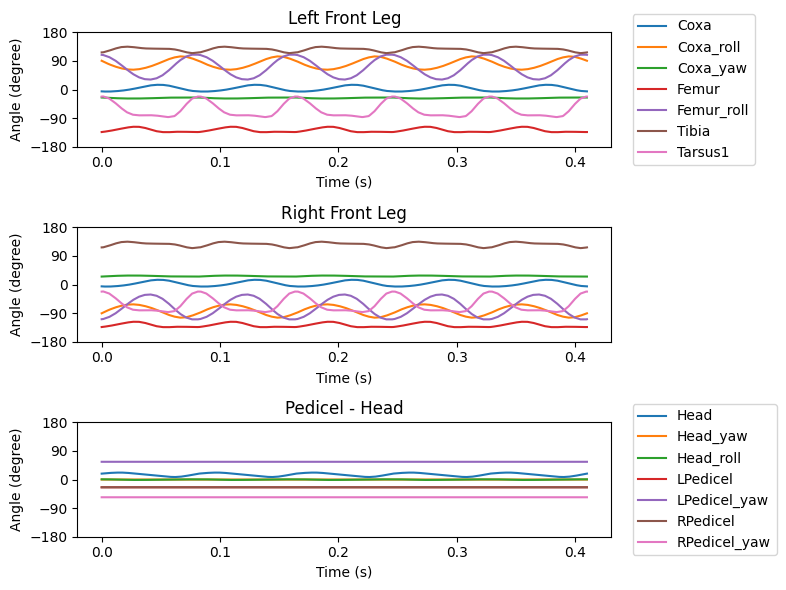

In [50]:
# mirror the left front leg data
data_block_eye_grooming_smoothed_mirrored = np.zeros_like(
    data_block_bilat_grooming_smoothed
)
for i, joint in enumerate(nmf.actuated_joints):
    if joint.startswith("joint_L"):
        data_block_eye_grooming_smoothed_mirrored[
            i, :
        ] = data_block_bilat_grooming_smoothed[i, :]
        continue
    if "Head" in joint:
        opp_joints_id = i
    elif joint.startswith("joint_L"):
        opp_joints_id = i
    else:
        opp_joints_id = nmf.actuated_joints.index(joint.replace("joint_R", "joint_L"))
    if "yaw" in joint or "roll" in joint:
        data_block_eye_grooming_smoothed_mirrored[
            i, :
        ] = -data_block_bilat_grooming_smoothed[opp_joints_id, :]
    else:
        data_block_eye_grooming_smoothed_mirrored[
            i, :
        ] = data_block_bilat_grooming_smoothed[opp_joints_id, :]

# add some coxa roll set the head roll to 0
data_block_eye_grooming_smoothed_mirrored[all_groom_dofs.index("joint_Head_yaw"), :] = 0

data_block_eye_grooming_smoothed_mirrored[
    all_groom_dofs.index("joint_LFCoxa_roll"), :
] += np.deg2rad(30)
data_block_eye_grooming_smoothed_mirrored[
    all_groom_dofs.index("joint_RFCoxa_roll"), :
] -= np.deg2rad(30)
data_block_eye_grooming_smoothed_mirrored[
    all_groom_dofs.index("joint_RFTibia"), :
] += np.deg2rad(20)
data_block_eye_grooming_smoothed_mirrored[
    all_groom_dofs.index("joint_LFTibia"), :
] += np.deg2rad(20)


data_block_eye_grooming_interp_cycled = np.tile(
    data_block_eye_grooming_smoothed_mirrored, n_cycles
)
fig = plot_grooming_kinematics(data_block_eye_grooming_interp_cycled, time)

In [51]:
nmf = NeuromechflyGrooming(sim_params=sim_params)

# replay the cycled grooming
obs, info = nmf.reset()

target_num_steps = data_block_eye_grooming_interp_cycled.shape[1]

for i in trange(target_num_steps):
    joint_pos = data_block_eye_grooming_interp_cycled[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

# as the left bilatenna is groomed, we call it left bilatennal grooming
nmf.save_video("visu/grooming_Eye_looped.mp4", 0)

100%|██████████| 2050/2050 [00:02<00:00, 993.14it/s] 


# Save every module extracted data

In [52]:
grooming_modules = {
    "foreleg": data_block_foreleg_grooming_smoothed,
    "R_antenna": data_block_ant_grooming_smoothed,
    "L_antenna": data_block_ant_grooming_smoothed_mirrored,
    "eyes": data_block_eye_grooming_smoothed_mirrored,
    "timestep": timestep,
}
if timestep == 2e-4:
    out_file = "data/grooming_modules_provided_fast.pkl"
elif timestep == 1e-4:
    out_file = "data/grooming_modules_provided_slow.pkl"
with open(out_file, "wb") as f:
    pickle.dump(grooming_modules, f)